# Introduction to Deep Learning with Keras and TensorFlow

**Ramy Rashad (KFUPM)**

**Resources: [Daniel Moser](https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb#scrollTo=Hs3ufCQvObnI), [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras), [MIT Introduction to Deep Learning](https://github.com/aamini/introtodeeplearning/tree/master/lab2)**

*To* help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with high accuracy. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.




## The Task for the AI agent

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images.

<img src="https://github.com/romeoVh/KFUPM_Teaching/blob/main/img/mnist.png?raw=1" width=400>

We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/romeoVh/KFUPM_Teaching/blob/main/img/tensorflow_keras_logos.jpg?raw=1" width=400>

TensorFlow is an open-source machine learning framework developed by Google. It's widely used for building and deploying machine learning models, particularly neural networks. TensorFlow provides a flexible platform that supports various types of machine learning, including deep learning, and is commonly used in research and production environments.

Keras is an open-source deep learning framework that provides a user-friendly API for building and training neural networks. It is written in Python and is designed to enable fast experimentation with deep neural networks. Keras allows users to create models with minimal code, making it accessible for both beginners and experts in machine learning.

Google Colab comes pre-installed with TensorFlow and Keras, so you don’t need to install them manually.




## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [1]:
%matplotlib inline
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import time

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
#import keras

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used
from keras.optimizers import SGD,Adam

from keras.layers import Input, Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import to_categorical # A useful function that will be used for pre-processing the labels

TensorFlow version: 2.17.0


## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [2]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
X_test shape (10000, 28, 28)
y_train shape (60000,)
y_test shape (10000,)


Let's visualize what some of these images and their corresponding training labels look like.
Using matplotlib, we will plot a random sample of 9 images from the training set directly into this Jupyter Notebook.

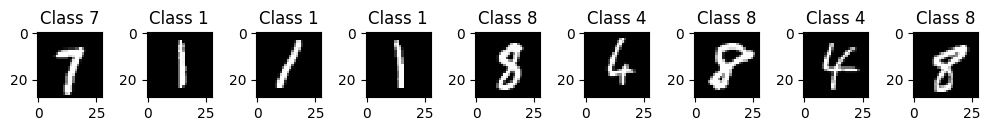

In [3]:
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(1,9,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Each image in the dataset consists of a 28 x 28 array(matrix) of pixels.
Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.
To see that, let's examine a single digit a little closer!
We will print out the array representing the last digit that was displayed above (in the lower right corner).

In [4]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[num])

0  0  0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    6   77   77  186  255  151   0  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0    0    0   34   74  159  254  254  254  254  242  35  0  0  0  0  
0  0  0  0  0  0  0  0   0    0    0    0    0   32  153  241  254  254  254  25

## Formatting the input data layer

Instead of a 28 x 28 matrix, we want to [link text](https://)build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale. In other words, main goal of normalization is to equalize the relative importance of the dimensions of the input.

<img src='https://github.com/romeoVh/KFUPM_Teaching/blob/main/img/flatten.png?raw=1' width="600">

In [5]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


## Formatting the labels

We then modify our label classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then the NN model has a 94% certainty that the image is that of the digit `1` and a 6% certainty that it is a `6`.

In [6]:
nb_classes = 10 # number of unique digits

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)
print("Training labels shape", Y_train.shape)
print("Testing labels shape", Y_test.shape)

Training labels shape (60000, 10)
Testing labels shape (10000, 10)


# First Try - Building a 2-layer fully connected network (FCN)

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task.
(Note that the input layer is usually not counted as a trainable layer).
Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

<img src='https://github.com/romeoVh/KFUPM_Teaching/blob/main/img/mnist_2layers_arch.png?raw=1' >

To define the architecture of this first fully connected neural network, we'll once again use the Keras API and define the model using the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) class.

In [7]:
model = Sequential() # The Sequential model is a linear stack of layers

### The hidden layer
The first hidden layer is a set of N nodes (artificial neurons).
Each node will receive an element from each input vector and apply some weight and bias to it.
We will use in this layer the ReLU activation.
An "activation" is a non-linear function applied to the output of the layer above.
It checks the new value of the node, and decides whether that artifical neuron has fired.
The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
Those inputs are then not considered to be fired.
Positive values of a node are unchanged.


$$f_{R}(x) = max (0,x)$$

In [8]:
N = 128
model.add(Input(shape=(784,)))
model.add(Dense(N))
model.add(Activation('relu'))

### The Output Layer
The final layer of 10 neurons in fully-connected to the previous N-node layer.
The final layer of a FCN should be equal to the number of desired classes (10 in this case).


In [9]:
model.add(Dense(10))

Now we use the softmax activation function to represent a probability distribution over K different possible outcomes.
Its values are all non-negative and sum to 1.
Each node of the output layer contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.


In [10]:
model.add(Activation('softmax'))

In [11]:
# Summarize the built model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Question: Do you know how to calculate the number of parameters of the network ?

Answer: .....


## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

Before training the model using Keras, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) step:

* *Loss function* — This defines how we measure how accurate the model is during training. During training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.

We'll start out by using the Stochastic Gradient Descent (SGD) optimizer initialized with the default learning rate of 0.01.



In [12]:
# Let's use the SGD optimizer for learning
our_optimizer = SGD() # default learning rate is 0.01
#our_optimizer = SGD(learning_rate=0.1)
#our_optimizer = Adam()


model.compile(loss='categorical_crossentropy', optimizer=our_optimizer, metrics=['accuracy'])

## Train the model!

We're now ready to train our model, which will involve feeding the training data (`train_images` and `train_labels`) into the model, and then asking it to learn the associations between images and labels.

This is where the magic happends, and usually the part where you go to sleep and come back another day.

We need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training.



The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

Then, we start the Neural Network training by calling the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) method on an instance of the `Model` class. We will use this to train our fully connected model.

In [13]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 128
EPOCHS = 5

# Record the start time
start_time = time.time()

# Start the Training
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5360 - loss: 1.6686
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8542 - loss: 0.6028
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8797 - loss: 0.4630
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8913 - loss: 0.4029
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8997 - loss: 0.3695


The two numbers printed above represent the overall accuracy of the network and the value of the loss function on the training data.
Note that the `history` variable is important for tracking the model's learning performance as will be shown later.


## Evaluate Model's Accuracy on Test Data

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before.
This is where things get messy !

In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array.

Use the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset!

In [14]:
score = model.evaluate(X_test, Y_test)
print(score)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8940 - loss: 0.3836
[0.33307865262031555, 0.9085999727249146]
Test score: 0.33307865262031555
Test accuracy: 0.9085999727249146


Question: What do you think of your AI model ? Does it satisfy you ? Why don't you try the Adam optimizer ?

Answer: ....

### Inspecting the output

Even if the accuracy you get satisfies you, it's always a good idea to inspect the output and make sure everything looks sane.
Also in case the model's performance is not what you expect, this is the stage where you start digging deep into the model's details to understand more on how it makes decisions.
Next we'll look at some examples the model gets right, and some examples it gets wrong.

The [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict) function call generates the output predictions given a set of input samples.
Recall that the output of our model is a probability distribution over the 10 digit classes. Thus, the ourput of the predict function describe the model's "confidence" that the image corresponds to each of the 10 different digits.



In [15]:
probabilities = model.predict(X_test, steps=1)

# Compute the highest probability class
# according to the trained classifier for each input example.
predicted_labels = np.argmax(probabilities, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_labels == y_test)[0]
incorrect_indices = np.nonzero(predicted_labels != y_test)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Let's print now some of the images it got right and some not.

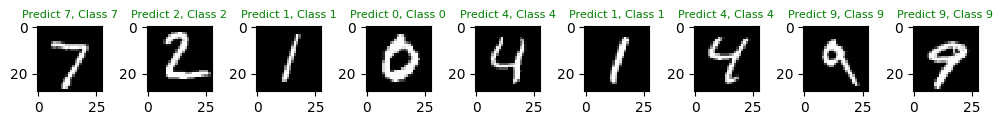

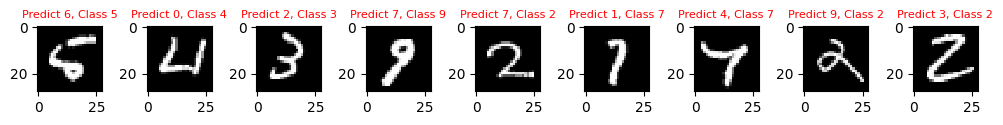

In [16]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(1,9,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none') # Note how we need to reshape the image back to 28 x 28
    plt.title("Predict {}, Class {}".format(predicted_labels[correct], y_test[correct]),color = 'green', fontsize=8)

plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(1,9,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predict {}, Class {}".format(predicted_labels[incorrect], y_test[incorrect]), color = 'red',fontsize = 8)

plt.tight_layout()

In [17]:
for i, incorrect in enumerate(incorrect_indices[:9]):
    print('Label predicted:',predicted_labels[incorrect])
    # print('Probabilities:', probabilities[incorrect]) # This prints the probabilities as fractions
    print(" ".join([f"{p * 100:.2f} " for p in probabilities[incorrect]])) # This prints the probabilities as percentages

Label predicted: 6
1.04  0.12  5.58  0.01  4.01  2.73  84.82  0.01  1.48  0.21 
Label predicted: 0
43.43  0.01  2.49  0.01  12.66  6.36  33.51  0.05  1.20  0.29 
Label predicted: 2
0.20  0.48  50.98  38.91  0.38  1.70  0.44  0.16  4.93  1.82 
Label predicted: 7
0.02  0.90  0.56  2.64  0.05  0.19  0.01  44.85  11.38  39.41 
Label predicted: 7
0.07  0.15  6.11  0.37  0.23  0.13  0.17  89.09  0.27  3.40 
Label predicted: 1
0.01  51.71  2.89  4.19  0.06  0.16  0.05  31.08  3.31  6.54 
Label predicted: 4
0.00  0.02  0.00  0.19  61.81  0.43  0.02  9.11  1.35  27.07 
Label predicted: 9
0.21  14.32  3.26  3.92  15.66  1.66  7.43  0.90  9.53  43.11 
Label predicted: 3
1.40  0.12  36.53  46.40  0.00  9.91  0.01  0.00  5.63  0.00 


## Visualize Model Training History in Keras


dict_keys(['accuracy', 'loss'])


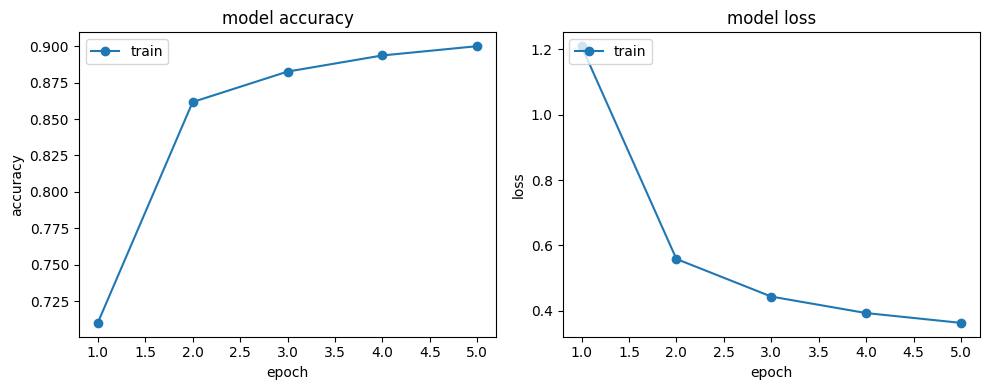

In [18]:
print(history.history.keys())

plt.figure(figsize=(10, 4))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, EPOCHS+1),history.history['accuracy'],'-o')
#plt.plot(history.history['val_accuracy']) # uncomment if you use validation data
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, EPOCHS+1),history.history['loss'],'-o')
#plt.plot(history.history['val_loss'])  # uncomment if you use validation data
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()


# Try experimenting with your Network!

Our Neural Network model had a number of adjustable parameters that determine its structure and how it is trained which directly affects its test accuracy and training time.
These adjustable parameters are called Hyper-parameters and selecting them is one of the most challenging tasks in Machine Learning in general.
For our Fully Connected Network, these parameters include:

- Number of hidden layers
- Activation function and number of nodes per layer
- Solver parameters, e.g. learning rate
- Batch size
- Number of iterations i.e. epochs
- Regularization (not discussed)


#### How does increasing the batch size to 10,000 affect the training time and test accuracy?

#### How about a batch size of 32?

#### What about adding more layers?
